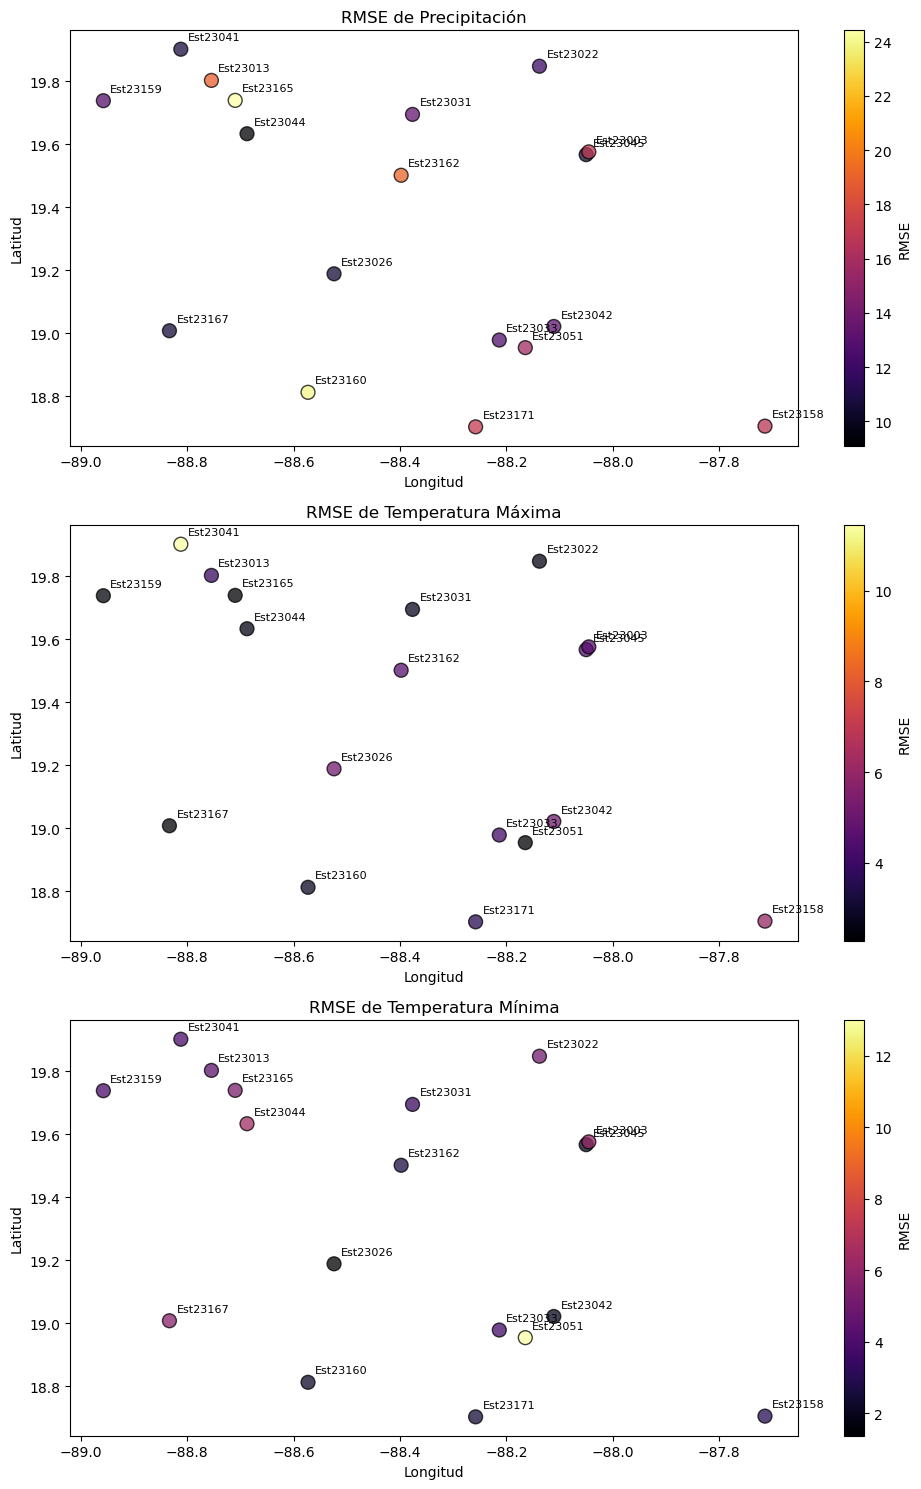

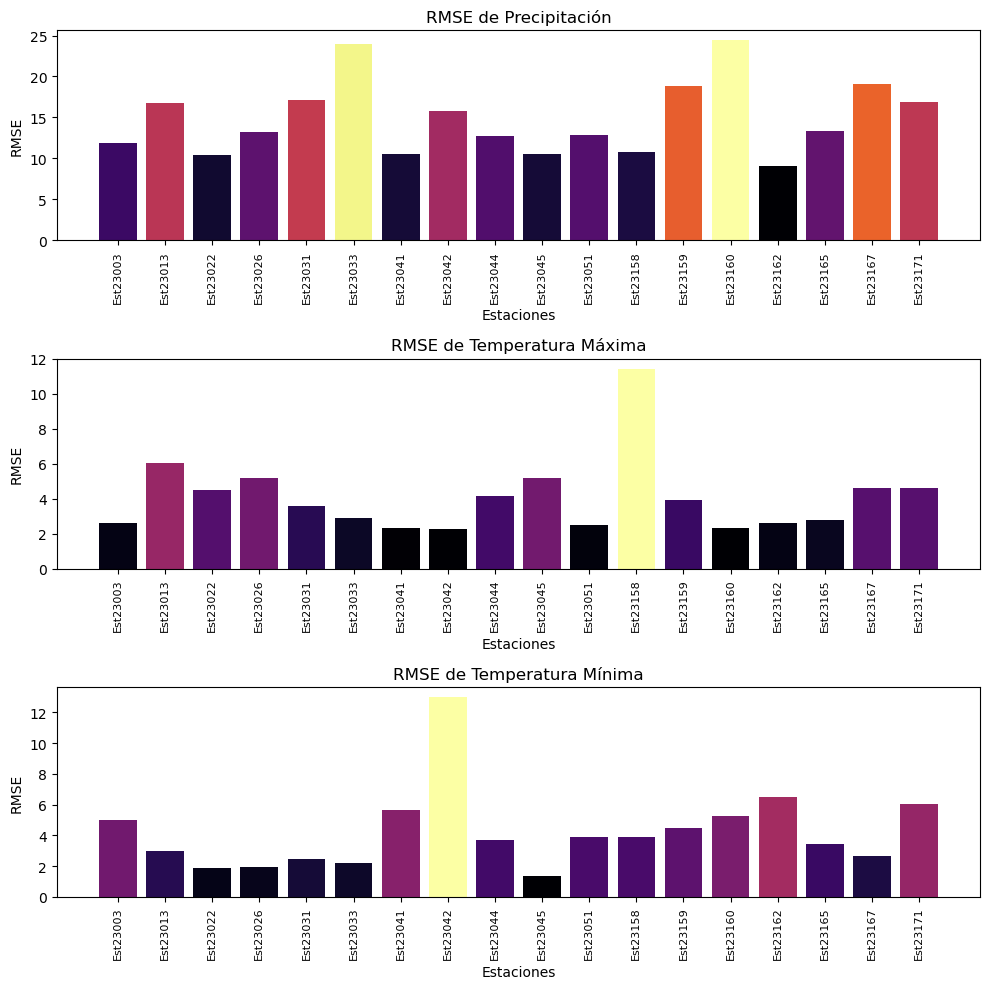

Tabla de RMSE:
    Estación  RMSE_Precipitación  RMSE_Temperatura_Máx  RMSE_Temperatura_Mín
0   Est23003           11.927994              2.604376              5.028795
1   Est23013           16.755383              6.031278              2.998399
2   Est23022           10.413964              4.516327              1.852127
3   Est23026           13.177218              5.163145              1.937486
4   Est23031           17.103477              3.586291              2.477005
5   Est23033           23.990034              2.902172              2.227765
6   Est23041           10.553985              2.344199              5.650842
7   Est23042           15.795198              2.275186             12.994020
8   Est23044           12.707552              4.132793              3.720740
9   Est23045           10.578064              5.194495              1.369321
10  Est23051           12.838559              2.488818              3.874195
11  Est23158           10.802678             11.446078       

In [1]:
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d
import os
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

def interpolate_missing_data(df):
    # Crear una copia del DataFrame para realizar la interpolación
    df_interpolated = df.copy()
    # Interpolar cada columna excepto 'Fecha' y 'Vel'
    for column in df_interpolated.columns:
        if column == 'Fecha' or column == 'Vel':
            continue
        # Convertir la columna a tipo numérico
        df_interpolated[column] = pd.to_numeric(df_interpolated[column], errors='coerce')
        # Encontrar índices de valores faltantes
        missing_indices = df_interpolated[column].isnull()
        # Interpolar datos faltantes usando interpolación lineal
        x = np.arange(len(df_interpolated[column]))
        # Limitar el rango de interpolación
        x_interp = x[~missing_indices]
        if len(x_interp) < 2:
            continue  # No hay suficientes datos para la interpolación lineal
        f = interp1d(x_interp, df_interpolated[column][~missing_indices], kind='linear', fill_value="extrapolate")
        interpolated_values = f(x[missing_indices])
        # Utilizar loc para asignar los valores interpolados
        df_interpolated.loc[missing_indices, column] = interpolated_values
    
    return df_interpolated

def calculate_rmse(df_real, df_pred):
    # Calcular el error cuadrático medio (ECM) para precipitación, Tmax y Tmin
    mse_values = {}
    for column in df_real.columns:
        if column in ['Fecha', 'EVAP', 'Vel']:
            continue
        mse_values[column] = np.mean((df_real[column] - df_pred[column])**2)
    # Calcular el RMSE
    rmse_values = {key: np.sqrt(value) for key, value in mse_values.items()}
    return rmse_values

# Diccionario con las ubicaciones de las estaciones
estaciones = {
    'Est23022': {'lon': -88.1378, 'lat': 19.8472},
    'Est23158': {'lon': -87.7139, 'lat': 18.7058},
    'Est23045': {'lon': -88.05, 'lat': 19.5667},
    'Est23042': {'lon': -88.1108, 'lat': 19.0219},
    'Est23171': {'lon': -88.2578, 'lat': 18.7036},
    'Est23160': {'lon': -88.5728, 'lat': 18.8131},
    'Est23167': {'lon': -88.8333, 'lat': 19.0083},
    'Est23051': {'lon': -88.1644, 'lat': 18.9547},
    'Est23033': {'lon': -88.2133, 'lat': 18.9789},
    'Est23026': {'lon': -88.5239, 'lat': 19.1889},
    'Est23159': {'lon': -88.9575, 'lat': 19.7378},
    'Est23041': {'lon': -88.8119, 'lat': 19.9011},
    'Est23013': {'lon': -88.7544, 'lat': 19.8022},
    'Est23165': {'lon': -88.7097, 'lat': 19.7389},
    'Est23044': {'lon': -88.6875, 'lat': 19.6331},
    'Est23031': {'lon': -88.3764, 'lat': 19.6944},
    'Est23162': {'lon': -88.3978, 'lat': 19.5014},
    'Est23003': {'lon': -88.045, 'lat': 19.5756}
}

# Rutas de los directorios de datos reales y predichos
ruta_datos_reales = "/Users/roelriosleon/Downloads/SMN"
ruta_datos_predichos = "/Users/roelriosleon/Documents/Pronostico Num/NASA/"

# Lista de nombres de archivos
archivos_reales = ['Est23003.xlsx', 'Est23013.xlsx', 'Est23022.xlsx', 'Est23026.xlsx', 'Est23031.xlsx', 'Est23033.xlsx',
                   'Est23041.xlsx', 'Est23042.xlsx', 'Est23044.xlsx', 'Est23045.xlsx', 'Est23051.xlsx', 'Est23158.xlsx',
                   'Est23159.xlsx', 'Est23160.xlsx', 'Est23162.xlsx', 'Est23165.xlsx', 'Est23167.xlsx', 'Est23171.xlsx']

# Diccionarios para almacenar los RMSE
rmse_precip = {}
rmse_tmax = {}
rmse_tmin = {}

# Procesar cada archivo
for archivo_real in archivos_reales:
    # Leer los datos reales
    df_real = pd.read_excel(os.path.join(ruta_datos_reales, archivo_real), na_values='Nulo')

    # Interpolar datos faltantes en los datos reales
    df_real_interpolated = interpolate_missing_data(df_real)

    # Leer los datos predichos
    archivo_predicho = archivo_real
    df_predicho = pd.read_excel(os.path.join(ruta_datos_predichos, archivo_predicho), na_values='Nulo')

    # Calcular el RMSE
    rmse_values = calculate_rmse(df_real_interpolated, df_predicho)

    # Almacenar los RMSE en los diccionarios correspondientes
    estacion = os.path.splitext(archivo_real)[0]
    rmse_precip[estacion] = rmse_values['PRECIP']
    rmse_tmax[estacion] = rmse_values['TMAX']
    rmse_tmin[estacion] = rmse_values['TMIN']

# Extraer ubicaciones y RMSE
lon = [estacion['lon'] for estacion in estaciones.values()]
lat = [estacion['lat'] for estacion in estaciones.values()]
rmse_precip_values = list(rmse_precip.values())
rmse_tmax_values = list(rmse_tmax.values())
rmse_tmin_values = list(rmse_tmin.values())

# Crear los mapas
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

# Mapa de RMSE de Precipitación
norm_precip = Normalize(vmin=min(rmse_precip_values), vmax=max(rmse_precip_values))
mapper_precip = ScalarMappable(norm=norm_precip, cmap='inferno')
scatter_precip = axs[0].scatter(lon, lat, s=100, c=rmse_precip_values, cmap='inferno', edgecolors='black', alpha=0.75)
for i, txt in enumerate(estaciones.keys()):
    axs[0].annotate(txt, (lon[i], lat[i]), xytext=(5, 5), textcoords='offset points', fontsize=8, ha='left', va='bottom')
axs[0].set_title('RMSE de Precipitación')
axs[0].set_xlabel('Longitud')
axs[0].set_ylabel('Latitud')
fig.colorbar(mapper_precip, ax=axs[0], label='RMSE')

# Mapa de RMSE de TMAX
norm_tmax = Normalize(vmin=min(rmse_tmax_values), vmax=max(rmse_tmax_values))
mapper_tmax = ScalarMappable(norm=norm_tmax, cmap='inferno')
scatter_tmax = axs[1].scatter(lon, lat, s=100, c=rmse_tmax_values, cmap='inferno', edgecolors='black', alpha=0.75)
for i, txt in enumerate(estaciones.keys()):
    axs[1].annotate(txt, (lon[i], lat[i]), xytext=(5, 5), textcoords='offset points', fontsize=8, ha='left', va='bottom')
axs[1].set_title('RMSE de Temperatura Máxima')
axs[1].set_xlabel('Longitud')
axs[1].set_ylabel('Latitud')
fig.colorbar(mapper_tmax, ax=axs[1], label='RMSE')

# Mapa de RMSE de TMIN
norm_tmin = Normalize(vmin=min(rmse_tmin_values), vmax=max(rmse_tmin_values))
mapper_tmin = ScalarMappable(norm=norm_tmin, cmap='inferno')
scatter_tmin = axs[2].scatter(lon, lat, s=100, c=rmse_tmin_values, cmap='inferno', edgecolors='black', alpha=0.75)
for i, txt in enumerate(estaciones.keys()):
    axs[2].annotate(txt, (lon[i], lat[i]), xytext=(5, 5), textcoords='offset points', fontsize=8, ha='left', va='bottom')
axs[2].set_title('RMSE de Temperatura Mínima')
axs[2].set_xlabel('Longitud')
axs[2].set_ylabel('Latitud')
fig.colorbar(mapper_tmin, ax=axs[2], label='RMSE')

plt.tight_layout()
plt.show()

# Crear gráficas
plt.figure(figsize=(10, 10))

# Gráfica para precipitación
plt.subplot(3, 1, 1)
colors_precip = mapper_precip.to_rgba(rmse_precip_values)
plt.bar(rmse_precip.keys(), rmse_precip.values(), color=colors_precip)
plt.title('RMSE de Precipitación')
plt.xlabel('Estaciones')
plt.ylabel('RMSE')
plt.xticks(rotation=90)
plt.tick_params(axis='x', labelsize=8)

# Gráfica para temperatura máxima
plt.subplot(3, 1, 2)
colors_tmax = mapper_tmax.to_rgba(rmse_tmax_values)
plt.bar(rmse_tmax.keys(), rmse_tmax.values(), color=colors_tmax)
plt.title('RMSE de Temperatura Máxima')
plt.xlabel('Estaciones')
plt.ylabel('RMSE')
plt.xticks(rotation=90)
plt.tick_params(axis='x', labelsize=8)

# Gráfica para temperatura mínima
plt.subplot(3, 1, 3)
colors_tmin = mapper_tmin.to_rgba(rmse_tmin_values)
plt.bar(rmse_tmin.keys(), rmse_tmin.values(), color=colors_tmin)
plt.title('RMSE de Temperatura Mínima')
plt.xlabel('Estaciones')
plt.ylabel('RMSE')
plt.xticks(rotation=90)
plt.tick_params(axis='x', labelsize=8)

plt.tight_layout()
plt.show()

# Crear DataFrame con los RMSE
rmse_df = pd.DataFrame({'Estación': list(rmse_precip.keys()),
                        'RMSE_Precipitación': list(rmse_precip.values()),
                        'RMSE_Temperatura_Máx': list(rmse_tmax.values()),
                        'RMSE_Temperatura_Mín': list(rmse_tmin.values())})

print("Tabla de RMSE:")
print(rmse_df)
